Base_anchors NP

In [1]:
import numpy as np
import tensorflow as tf

C:\Users\Royce\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess =tf.Session()

In [27]:
def base_anchor_np(base_size, ratios, scales):
    # 根据长宽比与缩放因子生成以中心点为原点的基准anchors
    ratios = np.expand_dims(ratios, axis=1) # (M, 1)
    scales = np.expand_dims(scales, axis=0) # (1, N)  
    # 根据已有的长宽比、缩放因子矩阵，得到两两结合的基于base_size的anchors长、宽
    h = np.sqrt(ratios) * scales * base_size
    w = 1.0 / np.sqrt(ratios) * scales * base_size
    # reshape为（-1，1）
    h = np.reshape(h, (-1, 1))
    w = np.reshape(w, (-1, 1))
    return np.hstack([-0.5*h, -0.5*w, 0.5*h, 0.5*w])

In [28]:
base_size = 128
ratios =[0.5, 1, 2]
scales = [1, 2, 4]

In [29]:
base_anchors_np = base_anchor_np(base_size, ratios, scales)

In [30]:
base_anchors_np

array([[ -45.254834  ,  -90.50966799,   45.254834  ,   90.50966799],
       [ -90.50966799, -181.01933598,   90.50966799,  181.01933598],
       [-181.01933598, -362.03867197,  181.01933598,  362.03867197],
       [ -64.        ,  -64.        ,   64.        ,   64.        ],
       [-128.        , -128.        ,  128.        ,  128.        ],
       [-256.        , -256.        ,  256.        ,  256.        ],
       [ -90.50966799,  -45.254834  ,   90.50966799,   45.254834  ],
       [-181.01933598,  -90.50966799,  181.01933598,   90.50966799],
       [-362.03867197, -181.01933598,  362.03867197,  181.01933598]])

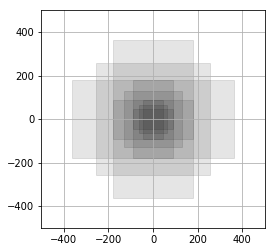

In [22]:
# 创建自定义图像，可视化基本的anchors
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
for a in base_anchors_np:
    y1,x1,y2,x2 = [int(i)for i in a]
    rect = matplotlib.patches.Rectangle((x1, y1),x2-x1, y2-y1, color='black',alpha=0.1)
    ax.add_patch(rect)
    plt.grid(True)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
plt.show()

Base_anchors TF

In [69]:
def base_anchors_tf(base_size, ratios, scales):
    # 输入参数值转tensor
    ratios = tf.constant(ratios, dtype=tf.float16)
    scales = tf.constant(scales, dtype=tf.float16)
    # 扩维
    ratios = tf.expand_dims(ratios, axis=1)
    scales = tf.expand_dims(scales, axis=0)
    # 长、宽计算
    h = tf.sqrt(ratios) * scales * base_size
    w = 1.0 / tf.sqrt(ratios) * scales * base_size
    # reshape
    h = tf.reshape(h, (-1, 1))
    w = tf.reshape(w, (-1, 1))
    return tf.concat([-0.5*h, -0.5*w, 0.5*h, 0.5*w], axis=1)
#     return tf.stack([-0.5*h, -0.5*w, 0.5*h, 0.5*w], axis=0)

In [70]:
base_size = 128
ratios =[0.5, 1, 2]
scales = [1, 2, 4]
base_anchors_tf = base_anchors_tf(base_size, ratios, scales)

In [71]:
print(sess.run(base_anchors_tf))

[[ -45.25  -90.5    45.25   90.5 ]
 [ -90.5  -181.     90.5   181.  ]
 [-181.   -362.    181.    362.  ]
 [ -64.    -64.     64.     64.  ]
 [-128.   -128.    128.    128.  ]
 [-256.   -256.    256.    256.  ]
 [ -90.5   -45.25   90.5    45.25]
 [-181.    -90.5   181.     90.5 ]
 [-362.   -181.    362.    181.  ]]


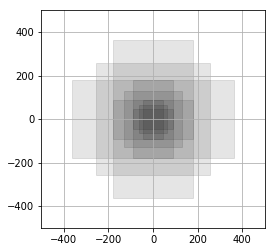

In [72]:
# 创建自定义图像，可视化基本的anchors
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
for a in sess.run(base_anchors_tf):
    y1,x1,y2,x2 = [int(i)for i in a]
    rect = matplotlib.patches.Rectangle((x1, y1),x2-x1, y2-y1, color='black',alpha=0.1)
    ax.add_patch(rect)
    plt.grid(True)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
plt.show()

Anchors shift NP

In [ ]:
# 基准anchors滑动过程中，中心点在原图上坐标的情况
def anchor_shift_np(base_anchor, strides, anchor_shape):
    # 首先找到所有的中心点
    center_x = (np.arrange(anchor_shape[1]) + 0.5) * strides[1]
    center_y = (np.arrange(anchor_shape[0]) + 0.5) * strides[0]
    # 然后
    